# Simple Classification with TensorlayerX

The dataset for this proof of concept is [Mobile Price Classification](https://www.kaggle.com/datasets/iabhishekofficial/mobile-price-classification) dataset. The goal is to make a simple ANN using TensorlayerX to classify how the phone's specification combination affect the price.

Since I can't find the meaning of the label, the price it self are classified as 4:
0 -> Cheapest
1 -> Cheap
2 -> Moderate
3 -> High

This classification endeavors to make a model that predicts the price type well, with highest accuracy using TensorlayerX API.

In [144]:
import pandas;

## 1. Data Loading

The data loading is done using Python Data Analysis (Pandas). The data consist of 2 csv files:

1. `train.csv` -> The data within will be used in this training session.
2. `test.csv` -> No Label (?) I think this will be used as Kaggle's competition. I will submit it once the model is cleared. We will jump to this data later.

In [145]:
dataframe = pandas.read_csv("train.csv");

### 1.1 Dataset Exploration

Exploration endeavors aims to find every information within data. But as the splits going, every information will be based-on train dataset.

In [146]:
print(f"Train data total: {dataframe.shape[0]}, Dimension: {dataframe.shape[1]}");

Train data total: 2000, Dimension: 21


In [147]:

dataframe.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


#### 1.1.1 Boxplot Analysis

This part will do boxplot analysis through all specifications within the data.

How to read Boxplot analysis?

```
-
|
|
= Q3
|
|
= Q2
|
|
= Q1
|
|
_
```

The outside of Q1 to Q3 are considered as an outlier. The outside of the - are considered as an anomaly.

The result of this analysis is in boxplot.png file.

In [148]:
import matplotlib.pyplot as plt;
import seaborn;

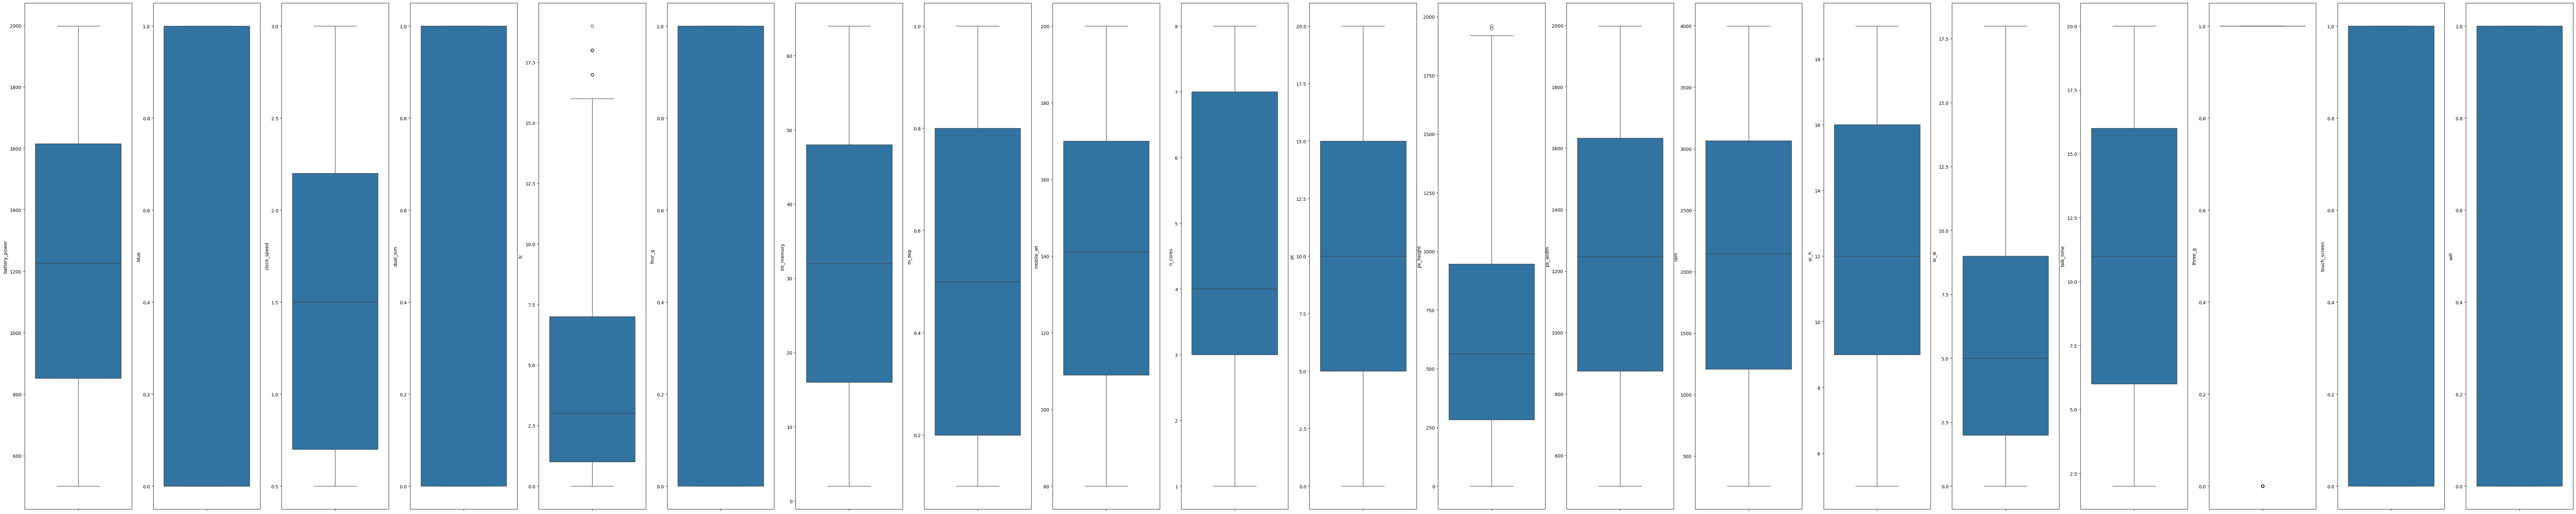

In [149]:
# Figure initialization
figure, axis = plt.subplots(ncols = 20, figsize = (100, 20)); # 20 is selected since the dimension of the data is 21, minus 1 for the label.

all_columns = dataframe.drop(columns = ["price_range"]).columns.values.tolist();

for i in range(len(all_columns)):
    seaborn.boxplot(dataframe[all_columns[i]], ax = axis[i]);

Hmmm. Some fc and px_height datas are having outlier. [I learned to read it from here.](https://d33wubrfki0l68.cloudfront.net/d85f905f355b234770b2450abc5f91900a218b55/8f9df/assets/images/posts/boxplot.png)

I think I will just use the outliers for the px_height part since phone's resolution may vary. But let's see what data correlation would says.

#### 1.1.2 Data Correlation Analysis

This part of the analysis, we will look at the correlation for every features with the label.

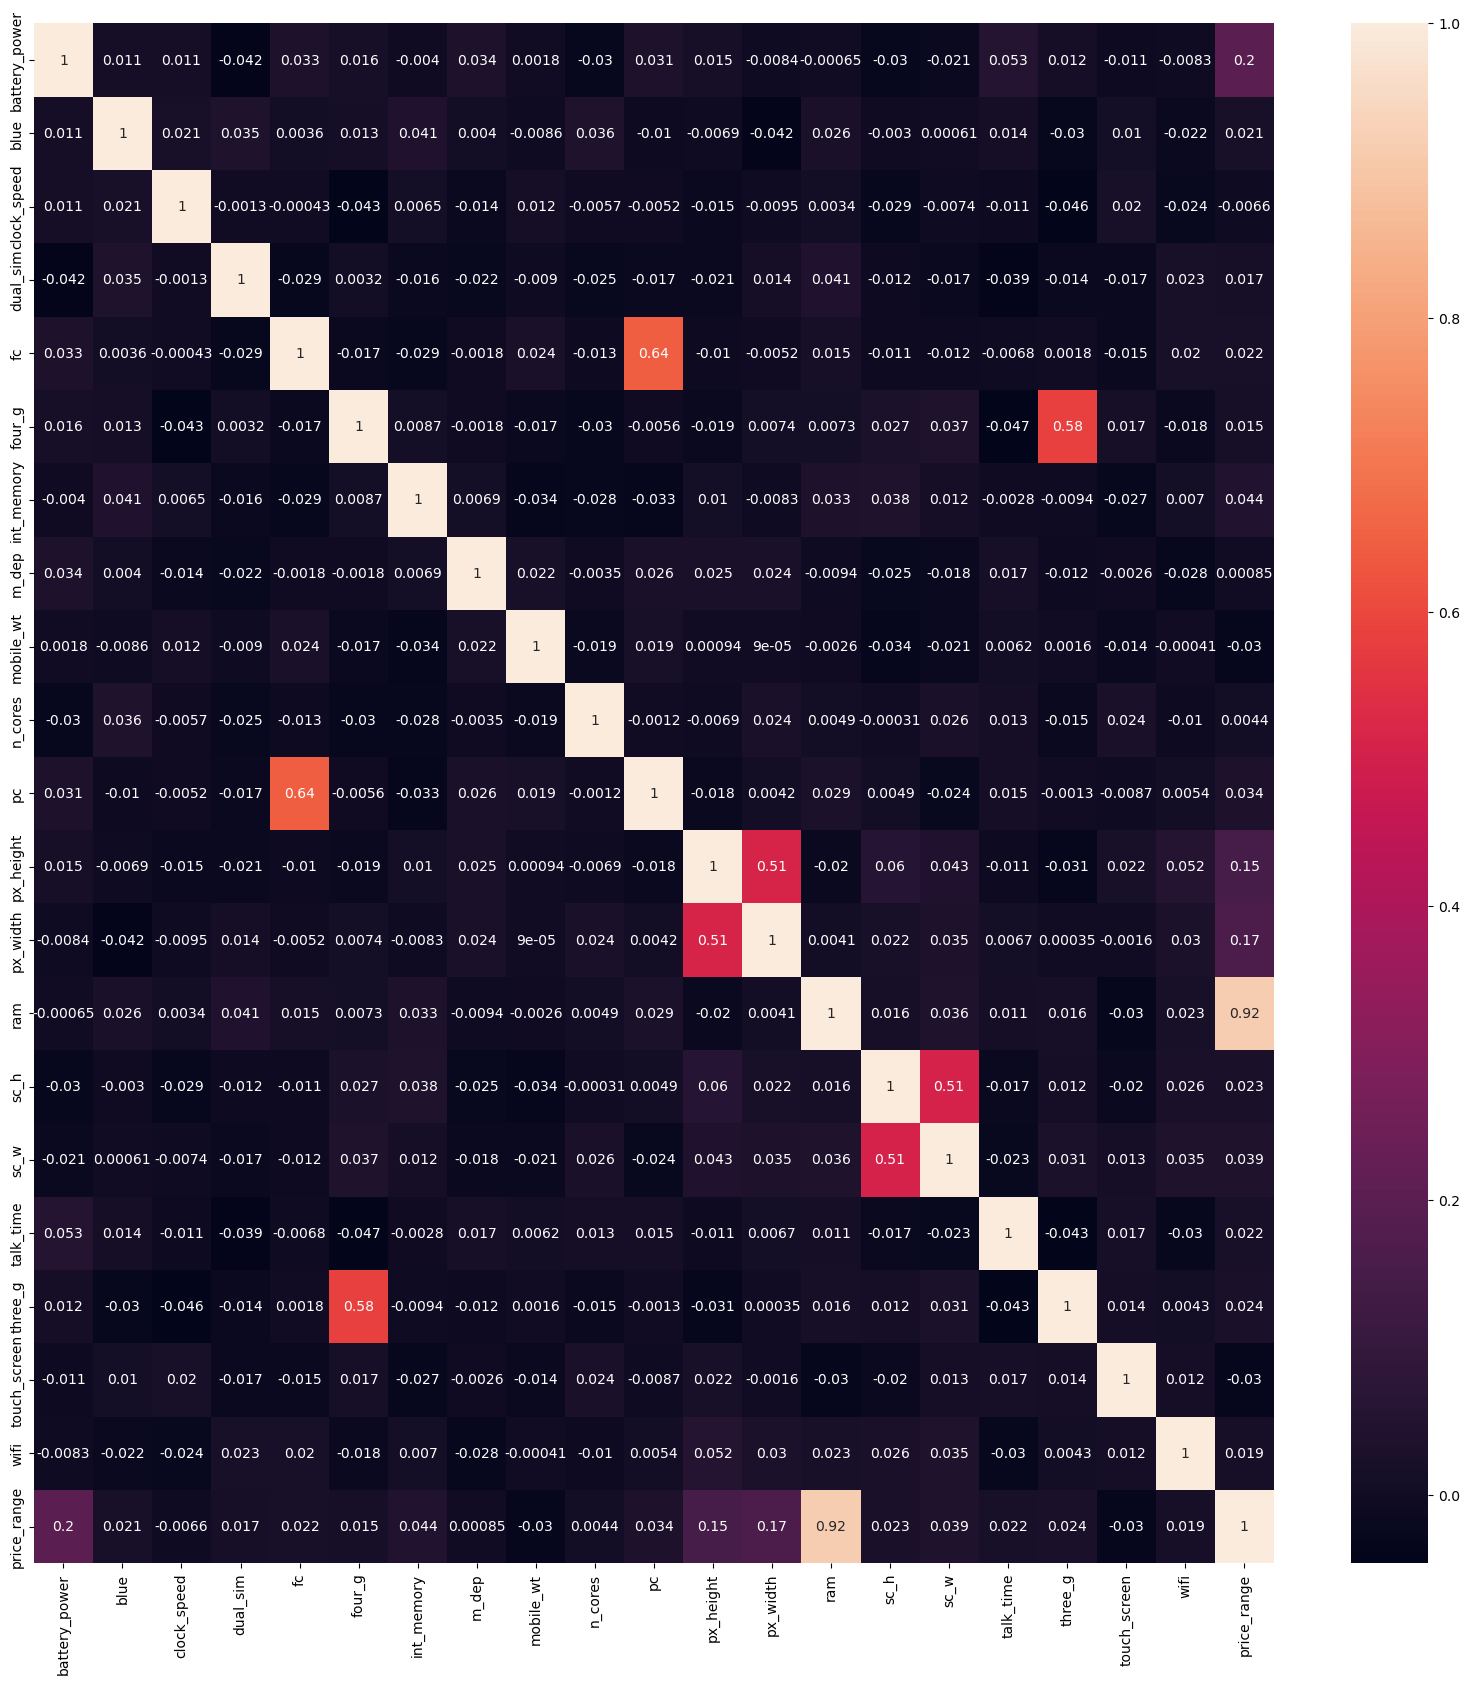

In [150]:
data_correlation = dataframe.corr();

plt.figure(figsize = (20, 20));
seaborn.heatmap(data_correlation, xticklabels = data_correlation.columns, yticklabels = data_correlation.columns, annot = True);

Since we are trying to find correlation for each features with the label, from the plotted data aboves, we can just see this row below:

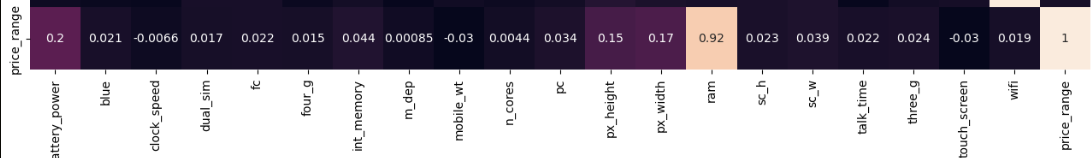

Seems like there aren't so many data with high positive / negative correlation. Other than these columns below:

| No | Column Name | Correlation Point |
|---|---|---|
| 1 | battery_power | 0,2 |
| 2 | px_height | 0,15 |
| 3 | px_width | 0,17 |
| 4 | ram | 0,92 |
| 5 | int_memory | 0,044 |

will be dropped as it is not really affecting the price_range column.

#### 1.1.3 Checking for any Missing Values

The checking for any missing values will be conducted in both train and test sets.

In [151]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

Pretty clean 'eh?

## 2 Data Pre-Processing Part 1

From information provided from the data exploration section, we then conduct these actions below:

1. Separating features from label for all train.csv files.
2. Splits train.csv file with ratio of 70:15:15 ratio for train, test, and validation sets.
3. Based-on correlation analysis, we drop everything other than battery_power, px_height, px_width, ram, int_memory from features. 
4. Perform One-Hot encoding to labels.

The data pre-processing will be done using Scikit-Learn, Numpy (via TensorlayerX) and Pandas.

In [152]:
# Separating features from label for train.csv files

features = dataframe.drop(columns = ["price_range"]);
labels = (dataframe["price_range"]).to_frame();

In [153]:
from sklearn.model_selection import train_test_split;
from sklearn.preprocessing import OneHotEncoder;

In [154]:
# Splits train.csv file with ratio of 70:15:15 ratio for train, test, and validation sets.

feature_train, feature_test, label_train, label_test = train_test_split(features, labels, train_size = 0.7, random_state = 42);

feature_test, feature_val, label_test, label_val = train_test_split(
    feature_test, 
    label_test, 
    train_size = 0.5, # Since to get 15% from 30% is by dividing it evenly, we divide the test from line 3 with 0.5. 
    random_state = 42
);

In [155]:
# Based-on correlation analysis, we drop everything other than battery_power, px_height, px_width, ram, int_memory from features.
saved_from_dropped = ["battery_power", "px_height", "px_width", "int_memory", "ram"];
dropped_columns = [];

for i in feature_train.columns.values.tolist():
    if(not (i in saved_from_dropped)):
        dropped_columns.append(i);

feature_train = feature_train.drop(columns = dropped_columns);
feature_test = feature_test.drop(columns = dropped_columns);
feature_val = feature_val.drop(columns = dropped_columns);

In [156]:
# Perform One-hot Encoding to label

encoder = OneHotEncoder();
label_train = encoder.fit_transform(label_train);
label_test = encoder.transform(label_test);
label_val = encoder.transform(label_val);

## 3 Data Pre-Processing Part 2

TensorlayerX required the data to be prepared in Data Loading pattern. This pattern will encapsulating the process of loading and preprocessing data. Since the rest of data pre-processing phase below will manipulating the nature of the data, like converting it to some data format, it is best to encapsulating it into a class. 

So what we will do in this part are:

1. Set Tensorlayerx's backend as Tensorflow
2. Create Data Loader class
3. Converts every value within features as tensor float32 since it is easier to model to read.
4. Register all train-test-val data with Data Loader

In [157]:
import tensorlayerx;
from tensorlayerx import expand_dims, convert_to_tensor, float32;
from tensorlayerx.dataflow import IterableDataset;


import os;

# Set Tensorlayerx's backend as Tensorflow
os.environ["TL_BACKEND"] = "tensorflow";

In [158]:
# Create Data Loader class

class DatasetLoader(IterableDataset):
    def __init__(self, feature, label):

        # Converts every value within features as tensor float32 since it is easier to model to read.
        self.data = expand_dims((feature.astype('float32')).values, axis = 1);
        self.label = expand_dims(label.toarray().astype('float32'), axis = 1);
    
        print(f"Data Shape: {self.data.shape}");
        print(f"Label Shape: {self.label.shape}");

    def __getitem__(self, index):
        data = self.data[index];
        label = self.label[index];

        return data, label;

    def __len__(self):
        return len(self.data);

    def __iter__(self):
        for i in range(len(self.data)):
            yield self.data[i], self.label[i];

In [159]:
# Register all train-test-val data with Data Loader

train_set_loader = DatasetLoader(feature_train, label_train);
test_set_loader = DatasetLoader(feature_test, label_test);
val_set_loader = DatasetLoader(feature_val, label_val);

Data Shape: (1400, 1, 5)
Label Shape: (1400, 1, 4)
Data Shape: (300, 1, 5)
Label Shape: (300, 1, 4)
Data Shape: (300, 1, 5)
Label Shape: (300, 1, 4)


In [160]:
train_set_loader.__getitem__(0)

(<tf.Tensor: shape=(1, 5), dtype=float32, numpy=array([[ 902.,   63.,  364., 1360., 3654.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0., 0., 0., 1.]], dtype=float32)>)

## 4. Model Architecture

Let the fun begin!

In [161]:
from tensorlayerx.nn import Module, Linear, Input;
from tensorlayerx import Softmax, ReLU, Sigmoid, Softplus;
from tensorlayerx.metrics import acc, Accuracy;
from tensorlayerx.losses import softmax_cross_entropy_with_logits, sigmoid_cross_entropy;
from tensorlayerx.optimizers import SGD;
from tensorlayerx.model import Model;

In [162]:
class NeuralNetwork(Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__();

        self.input = Input(shape = (5, ));
        self.linear1 = Linear(out_features = 64, in_features = 5, act = ReLU, name = "linear1");
        self.linear2 = Linear(out_features = 32, in_features = 64, act = ReLU, name = "linear2");
        self.linear3 = Linear(out_features = 16, in_features = 32, act = ReLU, name = "linear3");

        self.output = Linear(out_features = 4, in_features = 16, act = Softmax, name = "output");

    def forward(self, x):
        x = self.linear1(x);
        x = self.linear2(x);
        x = self.linear3(x);
        x = self.output(x);

        return x;

    def construct(self, x):
        x = self.input(x);

        x = self.linear1(x);
        x = self.linear2(x);
        x = self.linear3(x);
        out = self.output(x);

        return out;

# Create Model Pipeline
model = Model(
    network = NeuralNetwork(), 
    loss_fn = sigmoid_cross_entropy,
    optimizer = SGD(lr = 1e-1),
    metric_function = acc
);

model.train(n_epoch = 300, train_dataset = train_set_loader, test_dataset = val_set_loader, print_freq = 10);

[TLX] Input  _inputlayer_31: (5,)
[TLX] Linear  linear1: 64 ReLU
[TLX] Linear  linear2: 32 ReLU
[TLX] Linear  linear3: 16 ReLU
[TLX] Linear  output: 4 Softmax


Output()

Epoch 1 of 300 took 14.844352722167969

train loss: 0.7800368666648865

train acc:  0.6841071428571428

val loss: 0.7815085053443909